# FBA Simulations

This notebook performs flux balance analysis for R. opacus in glucose and phenol growth conditions.

### Methods: 
<ol>
<li>Calculate FBA and pFBA growth rates for each of the experimental conditions</li>
<li>Calculate EFLUX2 growth rates for each of the experimental conditions</li>
</ol>

### Imports

In [18]:
import pandas as pd
import numpy as np
import cobra
import matplotlib.pyplot as plt

### Load data from consumption and growth rate notebook (notebook E)

In [2]:
consumption_and_growth_data = pd.read_csv('../consumption_and_growth_data/consumption_and_growth_data.csv', index_col=0)
consumption_and_growth_data

,substrate consumption rate,substrate consumption rate std dev,growth rate,growth rate std dev,yield coefficient,yield coefficient std dev
Yoneda WT 1.5 g/L Phenol,0.703,0.033,0.019,0.001,0.027,0.003
Yoneda Evol33 1.5 g/L Phenol,1.014,0.021,0.034,0.002,0.033,0.002
Yoneda Evol40 1.5 g/L Phenol,0.943,0.030,0.034,0.001,0.036,0.002
"Yoneda WT 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",0.027,0.000,0.032,0.000,1.150,0.000
"Yoneda Evol33 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",0.043,0.000,0.031,0.000,0.726,0.000
"Yoneda Evol40 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",-0.063,0.000,0.031,0.000,-0.500,0.000
"Yoneda WT 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.021,0.000,0.039,0.000,1.834,0.000
"Yoneda Evol33 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.033,0.000,0.033,0.000,1.006,0.000
"Yoneda Evol40 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.017,0.000,0.034,0.000,2.029,0.000
Henson WT 0.5 g/L Phenol,1.422,0.129,0.065,0.001,0.046,0.005


### Load model 

In [3]:
model = cobra.io.read_sbml_model("../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml")
model

Name,ropacus_annotated_curated
Memory address,0x07f415651b2d0
Number of metabolites,1583
Number of reactions,2385
Number of groups,0
Objective expression,1.0*Growth - 1.0*Growth_reverse_699ae
Compartments,"cytosol, periplasm, extracellular space"


### Add FBA and pFBA growth rates to dataframe  (Note: something is wrong with pFBA growth rate calculation)

In [4]:
FBA_growth_rates = []
pFBA_growth_rates = []

for index, row in consumption_and_growth_data.iterrows():
    sub_uptake_rate = row['substrate consumption rate']
    with model:
        medium = model.medium
        if 'Phenol' in index:
            model.objective = 'Growth_Phenol'
            medium["EX_glc__D_e"] = 0.0
            medium["EX_phenol_e"] = sub_uptake_rate
        elif 'Glucose' in index:
            model.objective = 'Growth_Glucose'
            medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('unknown substrate')
        model.medium = medium
        
        FBA_solution = model.optimize().objective_value
        
        # This try except block prevents getting an infeasible pFBA solution
        try:
            pFBA_solution = cobra.flux_analysis.pfba(model).objective_value
        except:
            pFBA_solution = 0
            
        FBA_growth_rates.append(FBA_solution)
        pFBA_growth_rates.append(pFBA_solution)


consumption_and_growth_data['FBA growth rate'] = FBA_growth_rates
consumption_and_growth_data['pFBA growth rate'] = pFBA_growth_rates
consumption_and_growth_data

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


,substrate consumption rate,substrate consumption rate std dev,growth rate,growth rate std dev,yield coefficient,yield coefficient std dev,FBA growth rate,pFBA growth rate
Yoneda WT 1.5 g/L Phenol,0.703,0.033,0.019,0.001,0.027,0.003,0.067135,53.631913
Yoneda Evol33 1.5 g/L Phenol,1.014,0.021,0.034,0.002,0.033,0.002,0.096834,77.358122
Yoneda Evol40 1.5 g/L Phenol,0.943,0.030,0.034,0.001,0.036,0.002,0.090054,71.941527
"Yoneda WT 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",0.027,0.000,0.032,0.000,1.150,0.000,0.003193,1.990798
"Yoneda Evol33 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",0.043,0.000,0.031,0.000,0.726,0.000,0.005085,3.170531
"Yoneda Evol40 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",-0.063,0.000,0.031,0.000,-0.500,0.000,0.063014,0.000000
"Yoneda WT 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.021,0.000,0.039,0.000,1.834,0.000,0.002483,1.548399
"Yoneda Evol33 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.033,0.000,0.033,0.000,1.006,0.000,0.003902,2.433198
"Yoneda Evol40 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.017,0.000,0.034,0.000,2.029,0.000,0.002010,1.253466
Henson WT 0.5 g/L Phenol,1.422,0.129,0.065,0.001,0.046,0.005,0.135797,108.484466


### Add EFLUX2 growth rate to dataframe 

In [30]:
# TODO: Add this code

### Plot predicted vs measured growth rates

define function to calculate mean squared error

In [29]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

Plot data

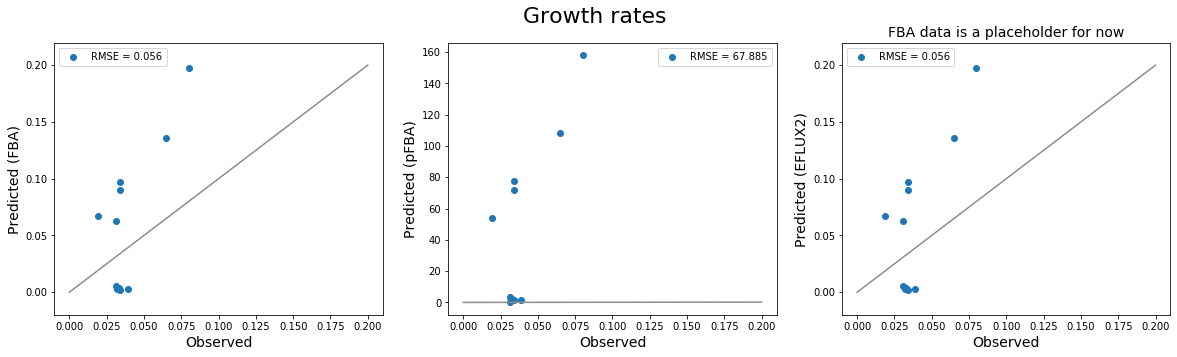

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Growth rates', fontsize=22)

# Left graph
axs[0].scatter(
    consumption_and_growth_data['growth rate'], 
    consumption_and_growth_data['FBA growth rate'], 
    label=f"RMSE = {rmse(consumption_and_growth_data['growth rate'], consumption_and_growth_data['FBA growth rate']):.3f}"
)
axs[0].plot([0.0, 0.2], [0.0, 0.2], 'k',  c='0.55')
axs[0].legend()
axs[0].set_xlabel('Observed', fontsize=14)
axs[0].set_ylabel('Predicted (FBA)', fontsize=14)


# Middle graph
axs[1].scatter(
    consumption_and_growth_data['growth rate'], 
    consumption_and_growth_data['pFBA growth rate'],
    label=f"RMSE = {rmse(consumption_and_growth_data['growth rate'], consumption_and_growth_data['pFBA growth rate']):.3f}"
)
axs[1].plot([0.0, 0.2], [0.0, 0.2], 'k',  c='0.55')
axs[1].legend()
axs[1].set_xlabel('Observed', fontsize=14)
axs[1].set_ylabel('Predicted (pFBA)', fontsize=14)


# Right graph
axs[2].set_title('FBA data is a placeholder for now', fontsize=14)
axs[2].scatter(
    consumption_and_growth_data['growth rate'], 
    consumption_and_growth_data['FBA growth rate'],
    label=f"RMSE = {rmse(consumption_and_growth_data['growth rate'], consumption_and_growth_data['FBA growth rate']):.3f}"
)
axs[2].plot([0.0, 0.2], [0.0, 0.2], 'k',  c='0.55')
axs[2].legend()
axs[2].set_xlabel('Observed', fontsize=14)
axs[2].set_ylabel('Predicted (EFLUX2)', fontsize=14)


plt.show()